<a href="https://colab.research.google.com/github/Rainniee/Neural-Networks-AI/blob/master/Experiment%201_Neural%20Style%20Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set Up

#### Download Images

In [0]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

#### Import and Configure Modules

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

We’ll begin by enabling [eager execution](https://www.tensorflow.org/guide/eager), which allows us to work through this technique in the clearest and most readable way. 

In [4]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
# Set up some global values here
content_path = '/tmp/nst/Tuebingen_Neckarfront.jpg'
style_path = '/tmp/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'

### Visualize the Input

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [0]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  
  if title is not None:
    plt.title(title)
  plt.imshow(out)

These are input content and style images. We hope to "create" an image with the content of our content image, but with the style of the style image. 


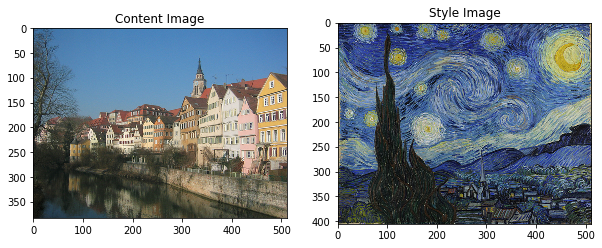

In [10]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

### Prepare the Data

Let's create methods that will allow us to load and preprocess our images easily. We perform the same preprocessing process as are expected according to the VGG training process. VGG networks are trained on image with each channel normalized by `mean = [103.939, 116.779, 123.68]`and with channels BGR.

In [0]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In order to view the outputs of our optimization, we are required to perform the inverse preprocessing step. Furthermore, since our optimized image may take its values anywhere between $- \infty$ and $\infty$, we must clip to maintain our values from within the 0-255 range.   

In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

### Define Content and Style Representation

In order to get both the content and style representations of our image, we will look at some intermediate layers within our model. As we go deeper into the model, these intermediate layers represent higher and higher order features. In this case, we are using the network architecture VGG19, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from our images. For an input image, we will try to match the corresponding style and content target representations at these intermediate layers. 

#### Why Intermediate Layers

You may be wondering why these intermediate outputs within our pretrained image classification network allow us to define style and content representations. At a high level, this phenomenon can be explained by the fact that in order for a network to perform image classification (which our network has been trained to do), it must understand the image. This involves taking the raw image as input pixels and building an internal representation through transformations that turn the raw image pixels into a complex understanding of the features present within the image. This is also partly why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g., cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed in and the classification label is output, the model serves as a complex feature extractor; hence by accessing intermediate layers, we’re able to describe the content and style of input images. 

Specifically we’ll pull out these intermediate layers from our network: 

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Build the Model

In this case, we load [VGG19](https://keras.io/applications/#vgg19), and feed in our input tensor to the model. This will allow us to extract the feature maps (and subsequently the content and style representations) of the content, style, and generated images.

We use VGG19, as suggested in the paper. In addition, since VGG19 is a relatively simple model (compared with ResNet, Inception, etc) the feature maps actually work better for style transfer. 

In order to access the intermediate layers corresponding to our style and content feature maps, we get the corresponding outputs and using the Keras [**Functional API**](https://keras.io/getting-started/functional-api-guide/), we define our model with the desired output activations. 

With the Functional API defining a model simply involves defining the input and output: 

`model = Model(inputs, outputs)`

In [15]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
layers = dict([(layer.name, layer.output) for layer in vgg.layers])
layers

{'block1_conv1': <tf.Tensor 'Relu_16:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_17:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'MaxPool_5:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_18:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_19:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'MaxPool_6:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_20:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_21:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_22:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'Relu_23:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'MaxPool_7:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_24:0' shape=(?, ?, ?, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_25:0' shape=(?, ?, ?, 512) dtype=float32>,

In [0]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In the above code snippet, we’ll load our pretrained image classification network. Then we grab the layers of interest as we defined earlier. Then we define a Model by setting the model’s inputs to an image and the outputs to the outputs of the style and content layers. In other words, we created a model that will take an input image and output the content and style intermediate layers!

### Define and Create Loss Functions

#### Content Loss

Our content loss definition is actually quite simple. We’ll pass the network both the desired content image and our base input image. This will return the intermediate layer outputs (from the layers defined above) from our model. Then we simply take the euclidean distance between the two intermediate representations of those images.  

More formally, content loss is a function that describes the distance of content from our output image $x$ and our content image, $p$. Let $C_{nn}$ be a pre-trained deep convolutional neural network. Again, in this case we use [VGG19](https://keras.io/applications/#vgg19). Let $X$ be any image, then $C_{nn}(X)$ is the network fed by X. Let $F^l_{ij}(x) \in C_{nn}(x)$ and $P^l_{ij}(p) \in C_{nn}(p)$ describe the respective intermediate feature representation of the network with inputs $x$ and $p$ at layer $l$. Then we describe the content distance (loss) formally as: $$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$

We perform backpropagation in the usual way such that we minimize this content loss. We thus change the initial image until it generates a similar response in a certain layer (defined in content_layer) as the original content image.

This can be implemented quite simply. Again it will take as input the feature maps at a layer L in a network fed by x, our input image, and p, our content image, and return the content distance.


**Computing Content Loss**

We will actually add our content losses at each desired layer. This way, each iteration when we feed our input image through the model (which in eager is simply `model(input_image)`) all the content losses through the model will be properly compute and because we are executing eagerly, all the gradients will be computed. 

In [0]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

#### Style Loss

Computing style loss is a bit more involved, but follows the same principle, this time feeding our network the base input image and the style image. However, instead of comparing the raw intermediate outputs of the base input image and the style image, we instead compare the Gram matrices of the two outputs. 

Mathematically, we describe the style loss of the base input image, $x$, and the style image, $a$, as the distance between the style representation (the gram matrices) of these images. We describe the style representation of an image as the correlation between different filter responses given by the Gram matrix  $G^l$, where $G^l_{ij}$ is the inner product between the vectorized feature map $i$ and $j$ in layer $l$. We can see that $G^l_{ij}$ generated over the feature map for a given image represents the correlation between feature maps $i$ and $j$. 

To generate a style for our base input image, we perform gradient descent from the content image to transform it into an image that matches the style representation of the original image. We do so by minimizing the mean squared distance between the feature correlation map of the style image and the input image. The contribution of each layer to the total style loss is described by
$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$

where $G^l_{ij}$ and $A^l_{ij}$ are the respective style representation in layer $l$ of $x$ and $a$. $N_l$ describes the number of feature maps, each of size $M_l = height * width$. Thus, the total style loss across each layer is 
$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$
where we weight the contribution of each layer's loss by some factor $w_l$. In our case, we weight each layer equally ($w_l =\frac{1}{|L|}$)

**Computing Style Loss**

In [0]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

### Apply Style Transfer To Test Images

#### Run Gradient Descent 

In this case, we use the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)* optimizer in order to minimize our loss. We iteratively update our output image such that it minimizes our loss: we don't update the weights associated with our network, but instead we train our input image to minimize loss. In order to do this, we must know how we calculate our loss and gradients. 

\* Note that L-BFGS, which is recommended; But here, we want to illustrate best practices with eager execution, and, by using Adam, we can demonstrate the autograd/gradient tape functionality with custom training loops.


We’ll define a little helper function that will load our content and style image, feed them forward through our network, which will then output the content and style feature representations from our model. 

In [0]:
def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

#### Computing the Loss and Gradients

Here we use [**tf.GradientTape**](https://www.tensorflow.org/programmers_guide/eager#computing_gradients) to compute the gradient. It allows us to take advantage of the automatic differentiation available by tracing operations for computing the gradient later. It records the operations during the forward pass and then is able to compute the gradient of our loss function with respect to our input image for the backwards pass.

In [0]:
"""This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
                  (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
                our optimization process. We apply the gradients wrt the loss 
                we are calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the defined 
                         style layers of interest.
    content_features: Precomputed outputs from defined content layers of interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss  
    
"""

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [0]:
# Compute the gradients:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
    
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

#### Optimization Loop

In [0]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

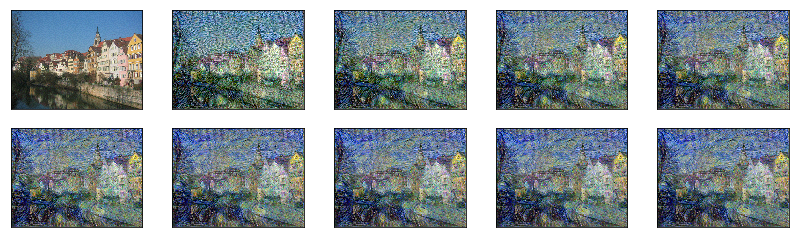

In [23]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

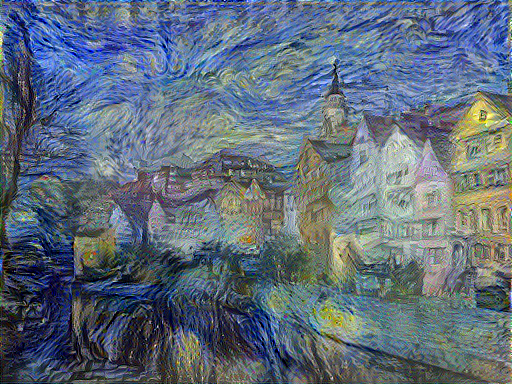

In [24]:
Image.fromarray(best)

### Try Other Images

#### Visualize the Output

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


We "deprocess" the output image in order to remove the processing that was applied to it.

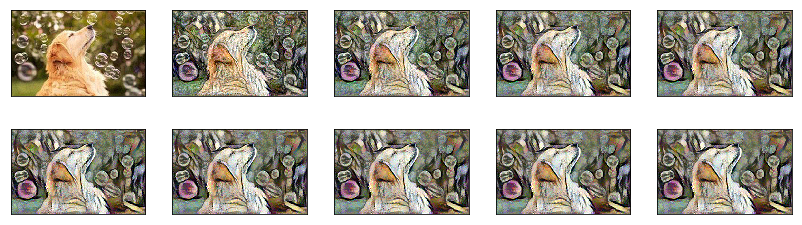

In [32]:
best_dog_styled, best_loss = run_style_transfer('drive/My Drive/Team 3 Final Project/dog.jpg',
                                                  'drive/My Drive/Team 3 Final Project/dora-maar-picasso.jpg')

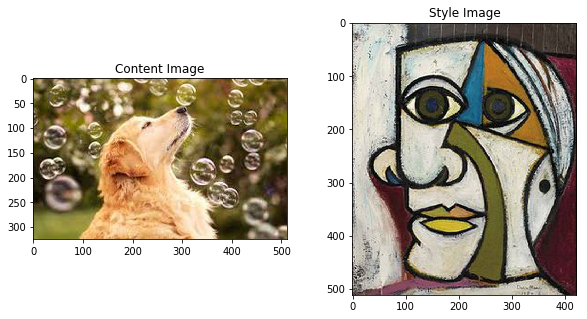

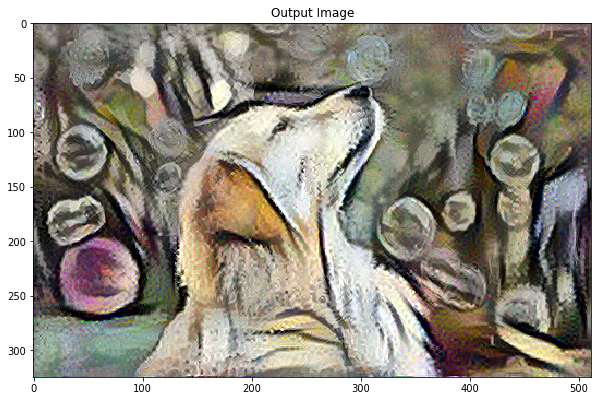

In [33]:
show_results(best_dog_styled, 'drive/My Drive/Team 3 Final Project/dog.jpg',
             'drive/My Drive/Team 3 Final Project/dora-maar-picasso.jpg')